In [4]:
import time
import imageio
from collections import deque, namedtuple
import gymnasium as gym
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn


In [5]:
        
# Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, num_actions):
        super(QNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(state_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_actions)
        )

    def forward(self, state):
        q_values = self.layers(state)
        return q_values


# Target Q-network
class TargetQNetwork(nn.Module):
    def __init__(self, state_size, num_actions):
        super(TargetQNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(state_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_actions)
        )

    def forward(self, state):
        q_values = self.layers(state)
        return q_values


class Reinforcement:
    def __init__(self, space_dim, action_dim):
        self.TAU = 1e-3  # Soft update parameter.
        self.ALPHA = 1e-3
        self.MINIBATCH_SIZE = 64
        self.GAMMA = 0.995
        self.learning_rate = 0.001
        self.epsilon = 1
        self.rewards = []
        self.total_points = []
        self.network = QNetwork(space_dim, action_dim)
        self.target_network = TargetQNetwork(space_dim, action_dim) #space_dim, action_dim
        self.optimizer = torch.optim.AdamW(
            self.network.parameters(),
            lr=self.learning_rate)
        
    def get_action(self, q_values):
        if random.random() > self.epsilon:
            return np.argmax(q_values.detach().numpy()[0])
        else:
            return random.choice(np.arange(2))
        
    def check_update_conditions(self, num_episode, num_steps_upd, 
                                memory_buffer):
        if (num_episode + 1) % num_steps_upd == 0 and len(memory_buffer) > self.MINIBATCH_SIZE:
            return True
        else:
            return False

    def update_epsilon(self):
        E_DECAY = 0.995  # epsilon-decay rate for the epsilon-greedy policy.
        E_MIN = 0.01  # Minimum epsilon value for the epsilon-greedy policy.
        self.epsilon = max(E_MIN, self.epsilon * E_DECAY)

    def get_experiences(self, memory_buffer):
        experiences = random.sample(memory_buffer, k=self.MINIBATCH_SIZE)
        states = torch.tensor(
            [e.state for e in experiences if e is not None], dtype=torch.float32
        )
        actions = torch.tensor(
            [e.action for e in experiences if e is not None], dtype=torch.float32
        )
        rewards = torch.tensor(
            [e.reward for e in experiences if e is not None], dtype=torch.float32
        )
        next_states = torch.tensor(
            [e.next_state for e in experiences if e is not None], dtype=torch.float32
        )
        done_vals = torch.tensor(
            [e.done for e in experiences if e is not None], dtype=torch.uint8
        ).float()  # Convert to float after creating the tensor

        return states, actions, rewards, next_states, done_vals
    
    def compute_loss(self, experiences):
        # Unpack the mini-batch of experience tuples
        states, actions, rewards, next_states, done_vals = experiences

        # Compute max Q^(s,a) using target network
        with torch.no_grad():  # No gradient computation for target network
            max_qsa = self.target_network(next_states).max(1)[0]  # max function returns both values and indices

        # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a)
        y_targets = rewards + (self.GAMMA * max_qsa * (1 - done_vals))

        # Get the q_values for the actions taken
        q_values = self.network(states).gather(1, actions.long().unsqueeze(-1)).squeeze(-1)

        # Compute the loss (Mean Squared Error)
        loss = torch.nn.functional.mse_loss(q_values, y_targets)

        return loss
    
    def learn(self, experiences):
        # Zero the gradients
        self.optimizer.zero_grad()

        # Calculate the loss
        loss = self.compute_loss(experiences)

        # # Backpropagate the loss
        loss.backward()

        # # Update the weights of the q_network
        self.optimizer.step()
        
        self.update_target_network()
    
        
    def update_target_network(self):
        for target_param, q_net_param in zip(self.target_network.parameters(), self.network.parameters()):
            target_param.data.copy_(self.TAU * q_net_param.data + (1.0 - self.TAU) * target_param.data)


In [6]:
def create_video(filename, env, q_network, fps=30):
    start = time.time()
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state, _ = env.reset()
        frame = env.render()
        video.append_data(frame)
        while not done:
            if time.time() - start > 20:
                break
            state = torch.from_numpy(np.expand_dims(state, axis=0))
            q_values = q_network(state)
            action = np.argmax(q_values.detach().numpy()[0])
            state, _, done, _, _ = env.step(action)
            frame = env.render()
            video.append_data(frame)

    env.close()

In [19]:
start = time.time()
MEMORY_SIZE = 100_000
FINISH_SCORE = 450
NUM_P_AVG = 100
env = gym.make('CartPole-v1', render_mode='rgb_array')
state_size = env.observation_space.shape[0]
num_actions = env.action_space.n
total_num_episodes = 4000
max_num_steps = 2000
total_points_hist = {
    3:[],
    5:[],
    7:[]
}
memory_buffer = deque(maxlen=MEMORY_SIZE)



experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


for x in [3,5,7]: #number of steps to update target network
    agent = Reinforcement(state_size, num_actions)
    for episode in range(total_num_episodes):
        state, _ = env.reset()
        total_points = 0
        for t in range(max_num_steps):
            state_qn = torch.from_numpy(np.expand_dims(state, axis=0))
            
            q_values = agent.network(state_qn)
            action = agent.get_action(q_values)
            next_state, reward, done, _, _ = env.step(action)
            
            memory_buffer.append(experience(state, action, reward, next_state, done))
            
            if(agent.check_update_conditions(t, x, memory_buffer)):
                minibatch_experiences = agent.get_experiences(memory_buffer)
                agent.learn(minibatch_experiences)

            state = next_state.copy()
            total_points += reward
            if done:
                break
            
        total_points_hist[x].append(total_points)
        avg_latest_points = np.mean(total_points_hist[x][-NUM_P_AVG:])
        
        
        #update epsilon
        agent.update_epsilon()
        
        print(f"\rEpisode {episode+1} | Total point average of the last {NUM_P_AVG} episodes: {avg_latest_points:.2f}: epsion = {agent.epsilon}", end="")

        if (episode+1) % NUM_P_AVG == 0:
            print(f"\rEpisode {episode+1} | Total point average of the last {NUM_P_AVG} episodes: {avg_latest_points:.2f}")
            
        # We will consider that the environment is solved if we get an
        # average of 200 points in the last 100 episodes.
        if avg_latest_points >= FINISH_SCORE:
            print(f"\n\nEnvironment solved in {episode+1} episodes!")
            # agent.network.save('Cart_pole_model.h5')
            torch.save(agent.network.state_dict(), 'Cart_pole_model.pth')
            break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")


create_video("CartPole_Pytorch.mp4", env, agent.network)




Episode 100 | Total point average of the last 100 episodes: 23.49: epsion = 0.6057704364907278
Episode 200 | Total point average of the last 100 episodes: 14.49: epsion = 0.36695782172616715
Episode 300 | Total point average of the last 100 episodes: 15.75: epsion = 0.22229219984074702
Episode 400 | Total point average of the last 100 episodes: 21.93: epsion = 0.13465804292601349
Episode 500 | Total point average of the last 100 episodes: 219.73: epsion = 0.08157186144027828
Episode 600 | Total point average of the last 100 episodes: 209.13: epsion = 0.049413822110038545
Episode 700 | Total point average of the last 100 episodes: 257.43: epsion = 0.029933432588273214
Episode 800 | Total point average of the last 100 episodes: 238.81: epsion = 0.018132788524664028
Episode 900 | Total point average of the last 100 episodes: 155.99: epsion = 0.010984307219379798
Episode 1000 | Total point average of the last 100 episodes: 131.91: epsion = 0.01036634861955105
Episode 1100 | Total point ave

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 1195 | Total point average of the last 100 episodes: 451.96: epsion = 0.01

Environment solved in 1195 episodes!

Total Runtime: 210.80 s (3.51 min)


/Users/brekigudmundsson/miniconda3/envs/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/brekigudmundsson/miniconda3/envs/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


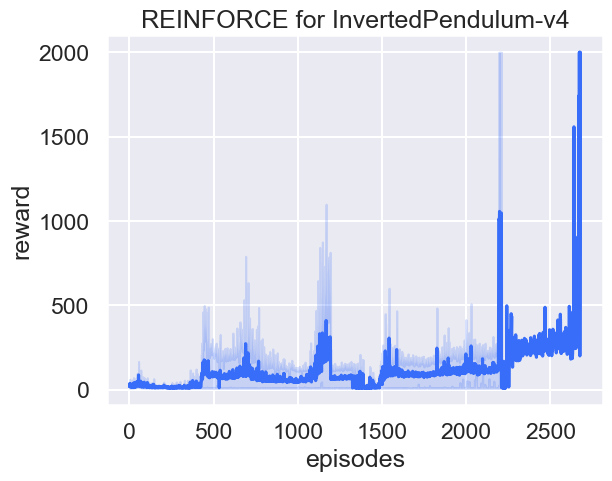

In [21]:
# rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
rewards_to_plot = [value for _, value in total_points_hist.items()]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for InvertedPendulum-v4"
)
plt.show()